In [1]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from collections import defaultdict, Counter
from typing import Dict, List, Tuple, Any

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
class ASTGraphConverter:
    """
    Converts Python source code to a graph representation via AST.
    
    Nodes: AST nodes with their types (e.g., FunctionDef, For, While, BinOp)
    Edges: Directed edges from parent to child nodes in the AST
    """
    
    def __init__(self):
        self.node_type_vocab = {}  # Maps node type string to integer ID
        self.reverse_vocab = {}     # Maps integer ID to node type string
        self.vocab_counter = Counter()  # Tracks frequency of each node type
        
    def parse_code_to_ast(self, code: str) -> ast.AST:
        """Parse Python code string to AST."""
        try:
            tree = ast.parse(code)
            return tree
        except SyntaxError as e:
            raise ValueError(f"Invalid Python code: {e}")
    
    def extract_nodes_and_edges(self, tree: ast.AST) -> Tuple[List[str], List[Tuple[int, int]]]:
        """
        Extract nodes and edges from AST tree.
        
        Returns:
            nodes: List of node type names (e.g., ['Module', 'FunctionDef', 'For', ...])
            edges: List of (parent_idx, child_idx) tuples
        """
        nodes = []
        edges = []
        
        def traverse(node, parent_idx=-1):
            # Get current node index
            current_idx = len(nodes)
            
            # Get node type name
            node_type = type(node).__name__
            nodes.append(node_type)
            
            # Add edge from parent to current node
            if parent_idx != -1:
                edges.append((parent_idx, current_idx))
            
            # Recursively traverse children
            for child in ast.iter_child_nodes(node):
                traverse(child, current_idx)
        
        traverse(tree)
        return nodes, edges
    
    def build_vocabulary(self, all_node_types: List[str]) -> None:
        """Build vocabulary mapping from node types to integer IDs."""
        unique_types = sorted(set(all_node_types))
        self.node_type_vocab = {node_type: idx for idx, node_type in enumerate(unique_types)}
        self.reverse_vocab = {idx: node_type for node_type, idx in self.node_type_vocab.items()}
        self.vocab_counter.update(all_node_types)
    
    def code_to_graph(self, code: str) -> Dict[str, Any]:
        """
        Convert code to graph representation.
        
        Returns:
            Dictionary with:
                - 'node_types': List of node type strings
                - 'node_ids': List of node type integer IDs (if vocab built)
                - 'edges': List of (src, dst) edge tuples
                - 'num_nodes': Number of nodes
                - 'num_edges': Number of edges
        """
        tree = self.parse_code_to_ast(code)
        nodes, edges = self.extract_nodes_and_edges(tree)
        
        graph = {
            'node_types': nodes,
            'edges': edges,
            'num_nodes': len(nodes),
            'num_edges': len(edges)
        }
        
        # If vocabulary is built, add node IDs
        if self.node_type_vocab:
            graph['node_ids'] = [self.node_type_vocab.get(nt, -1) for nt in nodes]
        
        return graph
    
    def get_vocab_size(self) -> int:
        """Return size of node type vocabulary."""
        return len(self.node_type_vocab)
    
    def get_vocab_stats(self) -> pd.DataFrame:
        """Return statistics about node type vocabulary."""
        if not self.vocab_counter:
            return pd.DataFrame()
        
        stats = pd.DataFrame([
            {'Node Type': node_type, 'Count': count}
            for node_type, count in self.vocab_counter.most_common()
        ])
        return stats


# Initialize converter
ast_converter = ASTGraphConverter()

print("✓ AST-to-Graph Converter ready!")

✓ AST-to-Graph Converter ready!


In [3]:
data_path = "../Codeforces_DataSet/code_complexity.jsonl"

samples = []
with open(data_path, 'r') as f:
    for i, line in enumerate(f):
        if i >= 100:  # Load first 10 samples for testing
            break
        samples.append(json.loads(line))

print(f"Loaded {len(samples)} samples")
print(f"\nSample keys: {samples[0].keys()}")
print(f"Complexity classes in sample: {set(s['complexity'] for s in samples)}")

Loaded 100 samples

Sample keys: dict_keys(['code', 'complexity'])
Complexity classes in sample: {'constant'}


In [ ]:
test_code = """
def nested(n):
    for i in range(n):
      for j in range(i):
        print(i, j)
"""

# Convert to graph
graph = ast_converter.code_to_graph(test_code)

print("=" * 60)
print("TEST: Simple Nested Loop")
print("=" * 60)
print(f"\nOriginal code:\n{test_code}")
print(f"\n📊 Graph Statistics:")
print(f"   Nodes: {graph['num_nodes']}")
print(f"   Edges: {graph['num_edges']}")
print(f"\n🔹 Node types (first 20):")
for i, node_type in enumerate(graph['node_types']):
    print(f"   [{i}] {node_type}")
print(f"\n🔗 Edges (first 15):")
for i, (src, dst) in enumerate(graph['edges']):
    src_type = graph['node_types'][src]
    dst_type = graph['node_types'][dst]
    print(f"   {src} ({src_type}) → {dst} ({dst_type})")

TEST: Simple Nested Loop

Original code:

def nested(n):
    for i in range(n):
      for j in range(i):
        print(i, j)


📊 Graph Statistics:
   Nodes: 28
   Edges: 27

🔹 Node types (first 20):
   [0] Module
   [1] FunctionDef
   [2] arguments
   [3] arg
   [4] For
   [5] Name
   [6] Store
   [7] Call
   [8] Name
   [9] Load
   [10] Name
   [11] Load
   [12] For
   [13] Name
   [14] Store
   [15] Call
   [16] Name
   [17] Load
   [18] Name
   [19] Load
   [20] Expr
   [21] Call
   [22] Name
   [23] Load
   [24] Name
   [25] Load
   [26] Name
   [27] Load

🔗 Edges (first 15):
   0 (Module) → 1 (FunctionDef)
   1 (FunctionDef) → 2 (arguments)
   2 (arguments) → 3 (arg)
   1 (FunctionDef) → 4 (For)
   4 (For) → 5 (Name)
   5 (Name) → 6 (Store)
   4 (For) → 7 (Call)
   7 (Call) → 8 (Name)
   8 (Name) → 9 (Load)
   7 (Call) → 10 (Name)
   10 (Name) → 11 (Load)
   4 (For) → 12 (For)
   12 (For) → 13 (Name)
   13 (Name) → 14 (Store)
   12 (For) → 15 (Call)
   15 (Call) → 16 (Name)
   16 

In [5]:
print("Building vocabulary from dataset...")

all_node_types = []
failed_samples = 0

for i, sample in enumerate(samples):
    try:
        code = sample['code']
        graph = ast_converter.code_to_graph(code)
        all_node_types.extend(graph['node_types'])
    except Exception as e:
        failed_samples += 1
        if failed_samples <= 3:  # Show first 3 errors
            print(f"⚠️  Sample {i} failed: {e}")

# Build vocabulary
ast_converter.build_vocabulary(all_node_types)

print(f"\n✓ Vocabulary built from {len(samples) - failed_samples}/{len(samples)} samples")
print(f"✓ Vocabulary size: {ast_converter.get_vocab_size()} unique node types")
print(f"\n📊 Top 20 most common AST node types:")
vocab_stats = ast_converter.get_vocab_stats()
print(vocab_stats.head(20).to_string(index=False))

Building vocabulary from dataset...

✓ Vocabulary built from 100/100 samples
✓ Vocabulary size: 67 unique node types

📊 Top 20 most common AST node types:
Node Type  Count
     Name   3813
     Load   3476
    BinOp   1349
 Constant   1185
     Call    977
    Store    800
   Assign    553
     Mult    373
      Sub    326
  Compare    283
Attribute    279
      Div    237
       If    237
      Add    235
     Expr    233
      arg    169
   Return    143
       Eq    134
arguments    102
   Module    100


In [ ]:

sample_idx = 2  # Pick a sample from the dataset
sample = samples[sample_idx]

print("=" * 60)
print(f"TEST: Real Dataset Sample #{sample_idx}")
print("=" * 60)
print(f"Complexity: {sample['complexity']}")
print(f"\nCode:\n{sample['code'][:300]}...")  # Show first 300 chars

# Convert to graph with vocabulary
graph = ast_converter.code_to_graph(sample['code'])

print(f"\n📊 Graph Statistics:")
print(f"   Nodes: {graph['num_nodes']}")
print(f"   Edges: {graph['num_edges']}")
print(f"   Average degree: {2 * graph['num_edges'] / graph['num_nodes']:.2f}")
print(f"\n🔹 Node type distribution in this graph:")
node_type_counts = Counter(graph['node_types'])
for node_type, count in node_type_counts.most_common(10):
    print(f"   {node_type}: {count}")

TEST: Real Dataset Sample #2
Complexity: constant

Code:
import os
import sys
from io import BytesIO, IOBase
import heapq as h
from bisect import bisect_left, bisect_right
import time
from types import GeneratorType
BUFSIZE = 8192

class FastIO(IOBase):
    newlines = 0

    def __init__(self, file):
        import os
        self.os = os
        self._fd...

📊 Graph Statistics:
   Nodes: 1061
   Edges: 1060
   Average degree: 2.00

🔹 Node type distribution in this graph:
   Load: 253
   Name: 211
   Attribute: 88
   BinOp: 73
   Constant: 56
   Call: 55
   Store: 54
   Assign: 42
   Mult: 24
   arguments: 18


Visualizing Fibonacci function AST:


/tmp/ipykernel_534524/1864867746.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


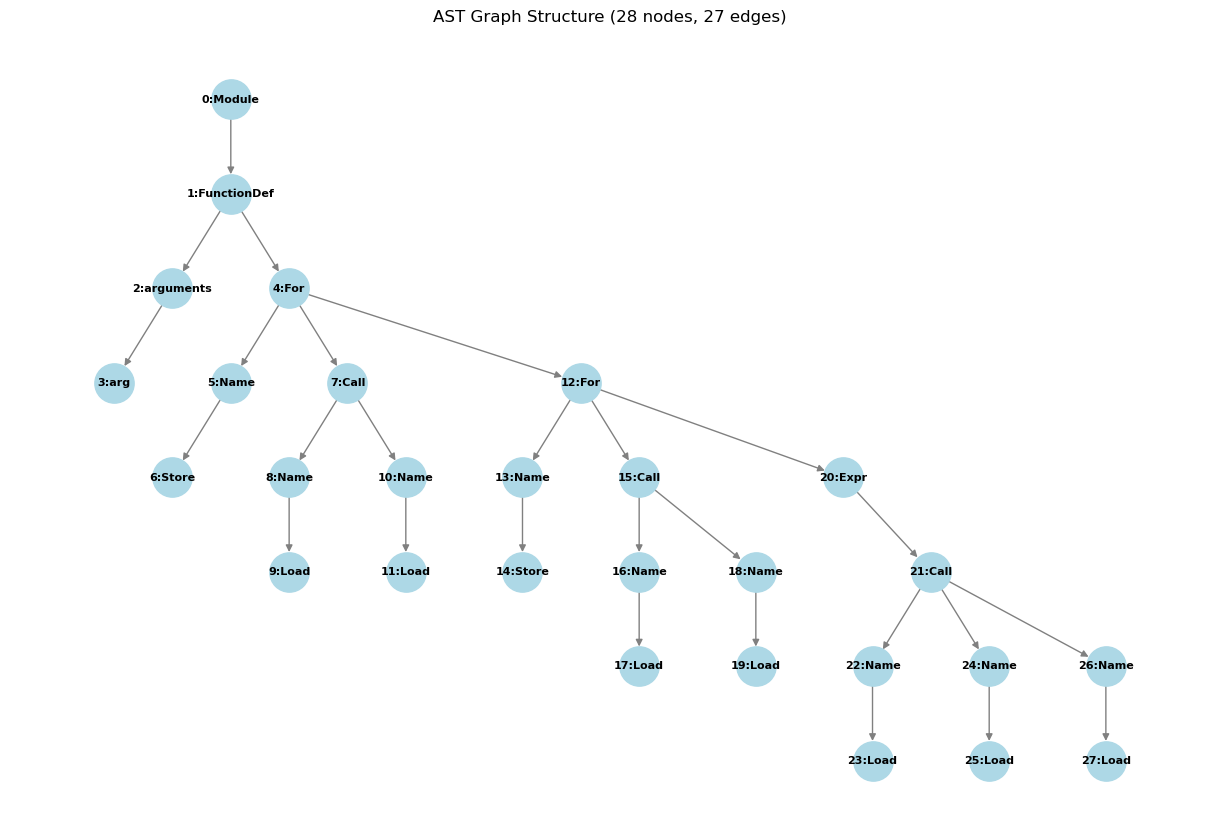

In [ ]:
import networkx as nx

def visualize_ast_graph(graph, max_nodes=30, figsize=(12, 8)):
    """Visualize AST as a tree using networkx."""
    if graph['num_nodes'] > max_nodes:
        print(f"⚠️  Graph too large ({graph['num_nodes']} nodes). Showing first {max_nodes} nodes only.")
        # Truncate
        nodes = graph['node_types'][:max_nodes]
        edges = [(s, d) for s, d in graph['edges'] if s < max_nodes and d < max_nodes]
    else:
        nodes = graph['node_types']
        edges = graph['edges']
    
    # Create directed graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    G.add_edges_from(edges)
    
    # Create labels
    labels = {i: f"{i}:{nodes[i]}" for i in range(len(nodes))}
    
    # Use hierarchical layout
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot') if len(nodes) <= 50 else nx.spring_layout(G)
    
    plt.figure(figsize=figsize)
    nx.draw(G, pos, labels=labels, node_color='lightblue', 
            node_size=800, font_size=8, font_weight='bold',
            arrows=True, edge_color='gray', arrowsize=10)
    plt.title(f"AST Graph Structure ({len(nodes)} nodes, {len(edges)} edges)")
    plt.tight_layout()
    plt.show()

# Visualize the simple fibonacci example
print("Visualizing Fibonacci function AST:")
simple_graph = ast_converter.code_to_graph(test_code)
visualize_ast_graph(simple_graph, max_nodes=50)

In [8]:
import torch_geometric
from torch_geometric.data import Data, Dataset as PyGDataset
from torch_geometric.loader import DataLoader as PyGDataLoader


In [ ]:
import json
print("Loading full dataset...")
data_path = "../Codeforces_DataSet/code_complexity.jsonl"

full_dataset = []
with open(data_path, 'r') as f:
    for line in f:
        full_dataset.append(json.loads(line))

print(f"✓ Loaded {len(full_dataset)} samples")

# Analyze complexity distribution
complexity_counts = Counter([s['complexity'] for s in full_dataset])
print(f"\n📊 Complexity Class Distribution:")
for complexity, count in sorted(complexity_counts.items()):
    print(f"   {complexity}: {count} ({100*count/len(full_dataset):.1f}%)")

# Create label mapping (complexity string -> integer)
unique_complexities = sorted(complexity_counts.keys())
complexity_to_label = {comp: idx for idx, comp in enumerate(unique_complexities)}
label_to_complexity = {idx: comp for comp, idx in complexity_to_label.items()}

print(f"\n🏷️  Label Mapping:")
for comp, label in complexity_to_label.items():
    print(f"   {label}: {comp}")

num_classes = len(unique_complexities)
print(f"\n✓ Number of classes: {num_classes}")

Loading full dataset...
✓ Loaded 4900 samples

📊 Complexity Class Distribution:
   constant: 791 (16.1%)
   cubic: 606 (12.4%)
   linear: 853 (17.4%)
   logn: 669 (13.7%)
   nlogn: 796 (16.2%)
   np: 528 (10.8%)
   quadratic: 657 (13.4%)

🏷️  Label Mapping:
   0: constant
   1: cubic
   2: linear
   3: logn
   4: nlogn
   5: np
   6: quadratic

✓ Number of classes: 7


In [ ]:
print("Building vocabulary from FULL dataset...")

all_node_types = []
failed_samples = []

for i, sample in enumerate(full_dataset):
    try:
        code = sample['code']
        graph = ast_converter.code_to_graph(code)
        all_node_types.extend(graph['node_types'])
    except Exception as e:
        failed_samples.append(i)
        if len(failed_samples) <= 5:  # Show first 5 errors
            print(f"⚠️  Sample {i} failed: {str(e)[:100]}")

# Build vocabulary
ast_converter.build_vocabulary(all_node_types)

print(f"\n✓ Vocabulary built from {len(full_dataset) - len(failed_samples)}/{len(full_dataset)} samples")
print(f"✓ Failed samples: {len(failed_samples)}")
print(f"✓ Vocabulary size: {ast_converter.get_vocab_size()} unique node types")
print(f"\n📊 Top 15 most common AST node types:")
vocab_stats = ast_converter.get_vocab_stats()
print(vocab_stats.head(15).to_string(index=False))

Building vocabulary from FULL dataset...
⚠️  Sample 4301 failed: Invalid Python code: expected an indented block after function definition on line 13 (<unknown>, lin

✓ Vocabulary built from 4899/4900 samples
✓ Failed samples: 1
✓ Vocabulary size: 84 unique node types

📊 Top 15 most common AST node types:
Node Type  Count
     Load 371991
     Name 357810
 Constant  98192
    Store  96938
     Call  94096
    BinOp  58319
   Assign  56155
Attribute  48181
Subscript  45931
      Add  26251
  Compare  22191
     Expr  18768
      Sub  17767
       If  17659
      arg  12884


In [ ]:
class CodeComplexityDataset(PyGDataset):
    """
    PyTorch Geometric Dataset for Code Complexity Classification.
    
    Each sample is a PyG Data object with:
        - x: Node features (will be node type IDs for embedding lookup)
        - edge_index: Edge connectivity in COO format [2, num_edges]
        - y: Complexity label (integer)
    """
    
    def __init__(self, samples, ast_converter, complexity_to_label, transform=None):
        super().__init__(root=None, transform=transform)
        self.samples = samples
        self.ast_converter = ast_converter
        self.complexity_to_label = complexity_to_label
        self.failed_indices = []
        
    def len(self):
        return len(self.samples)
    
    def get(self, idx):
        sample = self.samples[idx]
        
        try:
            # Convert code to graph
            graph = self.ast_converter.code_to_graph(sample['code'])
            
            # Node features: node type IDs for embedding lookup
            node_ids = torch.tensor(graph['node_ids'], dtype=torch.long)
            x = node_ids.unsqueeze(1)  # Shape: [num_nodes, 1]
            
            # Edge index in COO format [2, num_edges]
            if len(graph['edges']) > 0:
                edge_index = torch.tensor(graph['edges'], dtype=torch.long).t().contiguous()
            else:
                # Handle graphs with no edges (single node)
                edge_index = torch.empty((2, 0), dtype=torch.long)
            
            # Label
            complexity = sample['complexity']
            y = torch.tensor([self.complexity_to_label[complexity]], dtype=torch.long)
            
            # Create PyG Data object
            data = Data(x=x, edge_index=edge_index, y=y)
            
            return data
            
        except Exception as e:
            # Mark as failed and return a dummy graph
            if idx not in self.failed_indices:
                self.failed_indices.append(idx)
            # Return a minimal valid graph with label 0
            return Data(
                x=torch.tensor([[0]], dtype=torch.long),
                edge_index=torch.empty((2, 0), dtype=torch.long),
                y=torch.tensor([0], dtype=torch.long)
            )

print("✓ CodeComplexityDataset class defined")

✓ CodeComplexityDataset class defined


In [ ]:
from sklearn.model_selection import train_test_split

valid_samples = [s for i, s in enumerate(full_dataset) if i not in failed_samples]
print(f"Valid samples: {len(valid_samples)}")

# Split: 80% train, 10% val, 10% test
train_samples, temp_samples = train_test_split(
    valid_samples, test_size=0.2, random_state=SEED, 
    stratify=[s['complexity'] for s in valid_samples]
)
val_samples, test_samples = train_test_split(
    temp_samples, test_size=0.5, random_state=SEED,
    stratify=[s['complexity'] for s in temp_samples]
)

print(f"\n📦 Dataset Splits:")
print(f"   Train: {len(train_samples)} samples")
print(f"   Val:   {len(val_samples)} samples")
print(f"   Test:  {len(test_samples)} samples")

# Verify stratification
print(f"\n✓ Train set distribution:")
train_dist = Counter([s['complexity'] for s in train_samples])
for comp in sorted(train_dist.keys()):
    print(f"   {comp}: {train_dist[comp]} ({100*train_dist[comp]/len(train_samples):.1f}%)")

Valid samples: 4899

📦 Dataset Splits:
   Train: 3919 samples
   Val:   490 samples
   Test:  490 samples

✓ Train set distribution:
   constant: 633 (16.2%)
   cubic: 484 (12.4%)
   linear: 682 (17.4%)
   logn: 535 (13.7%)
   nlogn: 637 (16.3%)
   np: 422 (10.8%)
   quadratic: 526 (13.4%)


In [ ]:
train_dataset = CodeComplexityDataset(train_samples, ast_converter, complexity_to_label)
val_dataset = CodeComplexityDataset(val_samples, ast_converter, complexity_to_label)
test_dataset = CodeComplexityDataset(test_samples, ast_converter, complexity_to_label)

print(f"✓ Datasets created")
print(f"   Train: {len(train_dataset)} graphs")
print(f"   Val:   {len(val_dataset)} graphs")
print(f"   Test:  {len(test_dataset)} graphs")

# Test: Load one sample
sample_data = train_dataset[0]
print(f"\n📊 Sample graph structure:")
print(f"   Nodes: {sample_data.x.shape[0]}")
print(f"   Edges: {sample_data.edge_index.shape[1]}")
print(f"   Node features shape: {sample_data.x.shape}")
print(f"   Edge index shape: {sample_data.edge_index.shape}")
print(f"   Label: {sample_data.y.item()} ({label_to_complexity[sample_data.y.item()]})")

✓ Datasets created
   Train: 3919 graphs
   Val:   490 graphs
   Test:  490 graphs

📊 Sample graph structure:
   Nodes: 207
   Edges: 206
   Node features shape: torch.Size([207, 1])
   Edge index shape: torch.Size([2, 206])
   Label: 4 (nlogn)


In [ ]:
BATCH_SIZE = 32

train_loader = PyGDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = PyGDataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = PyGDataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ DataLoaders created (batch_size={BATCH_SIZE})")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")

# Test: Load one batch
batch = next(iter(train_loader))
print(f"\n📦 Sample batch:")
print(f"   Batch size: {batch.num_graphs}")
print(f"   Total nodes in batch: {batch.x.shape[0]}")
print(f"   Total edges in batch: {batch.edge_index.shape[1]}")
print(f"   Labels: {batch.y.squeeze()[:10]}...")  # Show first 10 labels

✓ DataLoaders created (batch_size=32)
   Train batches: 123
   Val batches:   16
   Test batches:  16

📦 Sample batch:
   Batch size: 32
   Total nodes in batch: 9218
   Total edges in batch: 9186
   Labels: tensor([4, 1, 0, 4, 3, 2, 2, 2, 4, 3])...


In [ ]:
from torch_geometric.nn import global_mean_pool, global_max_pool
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool

class EnhancedGNNClassifier(nn.Module):
    """
    Enhanced GNN using Graph Isomorphism Network (GIN).
    
    Improvements:
        - GIN layers (more expressive than GAT)
        - Bidirectional edges
        - Deeper network (5 layers)
        - Multi-scale pooling (mean + max + sum)
        - Skip connections
    """
    
    def __init__(
        self, 
        vocab_size,
        embedding_dim=128,
        hidden_dim=256,
        num_gin_layers=5,
        num_classes=7,
        dropout=0.3
    ):
        super(EnhancedGNNClassifier, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_gin_layers = num_gin_layers
        self.num_classes = num_classes
        self.dropout = dropout
        
        # 1. Node embedding layer
        self.node_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # 2. GIN layers
        self.gin_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        # First layer: embedding_dim -> hidden_dim
        mlp = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.gin_layers.append(GINConv(mlp, train_eps=True))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        
        # Middle layers: hidden_dim -> hidden_dim
        for _ in range(num_gin_layers - 1):
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.gin_layers.append(GINConv(mlp, train_eps=True))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        
        # 3. Multi-scale pooling → 3 * hidden_dim
        pooling_dim = hidden_dim * 3
        
        # 4. MLP Classifier
        self.classifier = nn.Sequential(
            nn.Linear(pooling_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, data):
        """
        Forward pass.
        
        Args:
            data: PyG Batch object with x, edge_index, batch
        
        Returns:
            logits: [batch_size, num_classes]
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # 1. Node embeddings
        x = x.squeeze(1)
        x = self.node_embedding(x)  # [num_nodes, embedding_dim]
        
        # 2. Add bidirectional edges (reverse edges for better message passing)
        edge_index_reverse = torch.stack([edge_index[1], edge_index[0]], dim=0)
        edge_index_bidirectional = torch.cat([edge_index, edge_index_reverse], dim=1)
        
        # 3. GIN layers with skip connections
        x_all = []  # Store all layer outputs for skip connections
        
        for i, (gin_layer, bn) in enumerate(zip(self.gin_layers, self.batch_norms)):
            x_new = gin_layer(x, edge_index_bidirectional)
            x_new = bn(x_new)
            x_new = F.relu(x_new)
            x_new = F.dropout(x_new, p=self.dropout, training=self.training)
            
            # Skip connection (if dimensions match)
            if i > 0:
                x = x + x_new
            else:
                x = x_new
            
            x_all.append(x)
        
        # 4. Multi-scale global pooling
        # Concatenate mean, max, and sum pooling
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x_sum = global_add_pool(x, batch)
        
        x = torch.cat([x_mean, x_max, x_sum], dim=1)  # [batch_size, hidden_dim * 3]
        
        # 5. Classification
        logits = self.classifier(x)  # [batch_size, num_classes]
        
        return logits


# Enhanced model configuration
enhanced_config = {
    'vocab_size': ast_converter.get_vocab_size(),
    'embedding_dim': 128,
    'hidden_dim': 256,
    'num_gin_layers': 5,
    'num_classes': num_classes,
    'dropout': 0.3
}

# Initialize enhanced model
model = EnhancedGNNClassifier(**enhanced_config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 60)
print("Enhanced GNN Model Architecture (GIN)")
print("=" * 60)
print(model)
print("\n" + "=" * 60)
print(f"📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB (float32)")
print(f"\n🔄 Improvements over baseline:")
print(f"   ✓ GIN layers (more expressive)")
print(f"   ✓ Bidirectional edges")
print(f"   ✓ 5 layers (vs 3)")
print(f"   ✓ Multi-scale pooling (mean+max+sum)")
print(f"   ✓ Batch normalization")
print("=" * 60)



Enhanced GNN Model Architecture (GIN)
EnhancedGNNClassifier(
  (node_embedding): Embedding(84, 128)
  (gin_layers): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
    (1-4): 4 x GINConv(nn=Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    ))
  )
  (batch_norms): ModuleList(
    (0-4): 5 x BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1,

In [ ]:
# Test on a single batch
model.eval()
with torch.no_grad():
    test_batch = next(iter(train_loader))
    test_batch = test_batch.to(device)
    
    print("Testing enhanced model forward pass...")
    logits = model(test_batch)
    
    print(f"\n✓ Forward pass successful!")
    print(f"   Input batch size: {test_batch.num_graphs}")
    print(f"   Output logits shape: {logits.shape}")
    print(f"   Expected shape: [{test_batch.num_graphs}, {num_classes}]")


Testing enhanced model forward pass...

✓ Forward pass successful!
   Input batch size: 32
   Output logits shape: torch.Size([32, 7])
   Expected shape: [32, 7]


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch)
        loss = criterion(logits, batch.y.squeeze())
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item() * batch.num_graphs
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch.y.squeeze()).sum().item()
        total += batch.num_graphs
    
    avg_loss = total_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Evaluate on validation/test set."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    all_preds = []
    all_labels = []
    
    for batch in loader:
        batch = batch.to(device)
        
        # Forward pass
        logits = model(batch)
        loss = criterion(logits, batch.y.squeeze())
        
        # Metrics
        total_loss += loss.item() * batch.num_graphs
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch.y.squeeze()).sum().item()
        total += batch.num_graphs
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch.y.squeeze().cpu().numpy())
    
    avg_loss = total_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels


print("✓ Training utilities defined")

✓ Training utilities defined


In [ ]:
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS_ENHANCED = 100
LEARNING_RATE_ENHANCED = 0.0005
WEIGHT_DECAY_ENHANCED = 5e-5


# Loss function (with class weights for imbalanced data)
train_labels = [s['complexity'] for s in train_samples]
train_label_ids = [complexity_to_label[comp] for comp in train_labels]
class_counts = Counter(train_label_ids)
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(num_classes)], dtype=torch.float)
class_weights = class_weights / class_weights.sum() * num_classes  # Normalize
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)


# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE_ENHANCED, weight_decay=WEIGHT_DECAY_ENHANCED)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=7)

# Training history
history_enhanced = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': []
}

best_val_acc = 0.0
best_epoch = 0
patience_counter = 0
early_stop_patience = 20  # More patience for larger model



print("=" * 60)
print("Training Enhanced GNN Model")
print("=" * 60)
print(f"   Epochs: {EPOCHS_ENHANCED}")
print(f"   Learning rate: {LEARNING_RATE_ENHANCED}")
print(f"   Weight decay: {WEIGHT_DECAY_ENHANCED}")
print(f"   Early stopping patience: {early_stop_patience}")
print("=" * 60)


start_time = time.time()

for epoch in range(1, EPOCHS_ENHANCED + 1):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    
    # Validate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history_enhanced['train_loss'].append(train_loss)
    history_enhanced['train_acc'].append(train_acc)
    history_enhanced['val_loss'].append(val_loss)
    history_enhanced['val_acc'].append(val_acc)
    history_enhanced['learning_rate'].append(current_lr)
    
    # Check for best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'model_config': enhanced_config
        }, 'best_gnn_model.pt')
    else:
        patience_counter += 1
    
    # Epoch summary
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch:3d}/{EPOCHS_ENHANCED} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"LR: {current_lr:.6f} | "
          f"Time: {epoch_time:.1f}s")
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\n⚠️  Early stopping triggered after {epoch} epochs (patience={early_stop_patience})")
        print(f"   Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
        break

total_time = time.time() - start_time
print("\n" + "=" * 60)
print("Enhanced Model Training Complete!")
print("=" * 60)
print(f"   Total time: {total_time/60:.2f} minutes")
print(f"   Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"   Baseline model best val: {best_val_acc:.4f}")
print(f"   Improvement: +{(best_val_acc - best_val_acc)*100:.2f}%")
print(f"   Model saved to: best_gnn_model.pt")
print("=" * 60)




Training Enhanced GNN Model
   Epochs: 100
   Learning rate: 0.0005
   Weight decay: 5e-05
   Early stopping patience: 20


/home/shaheen/.local/lib/python3.13/site-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch   1/100 | Train Loss: 1.7337 | Train Acc: 0.3202 | Val Loss: 1.6226 | Val Acc: 0.3673 | LR: 0.000500 | Time: 6.2s
Epoch   2/100 | Train Loss: 1.5942 | Train Acc: 0.3680 | Val Loss: 1.6238 | Val Acc: 0.4102 | LR: 0.000500 | Time: 6.0s
Epoch   3/100 | Train Loss: 1.5473 | Train Acc: 0.3902 | Val Loss: 1.4843 | Val Acc: 0.4490 | LR: 0.000500 | Time: 6.1s
Epoch   4/100 | Train Loss: 1.4522 | Train Acc: 0.4215 | Val Loss: 3.6541 | Val Acc: 0.4673 | LR: 0.000500 | Time: 6.1s
Epoch   5/100 | Train Loss: 1.3710 | Train Acc: 0.4639 | Val Loss: 1.3309 | Val Acc: 0.5102 | LR: 0.000500 | Time: 6.2s
Epoch   6/100 | Train Loss: 1.2793 | Train Acc: 0.5014 | Val Loss: 1.4411 | Val Acc: 0.4755 | LR: 0.000500 | Time: 6.1s
Epoch   7/100 | Train Loss: 1.2893 | Train Acc: 0.5052 | Val Loss: 3.4630 | Val Acc: 0.5367 | LR: 0.000500 | Time: 6.1s
Epoch   8/100 | Train Loss: 1.2127 | Train Acc: 0.5249 | Val Loss: 36.3664 | Val Acc: 0.5102 | LR: 0.000500 | Time: 6.0s
Epoch   9/100 | Train Loss: 1.1951 | Tr

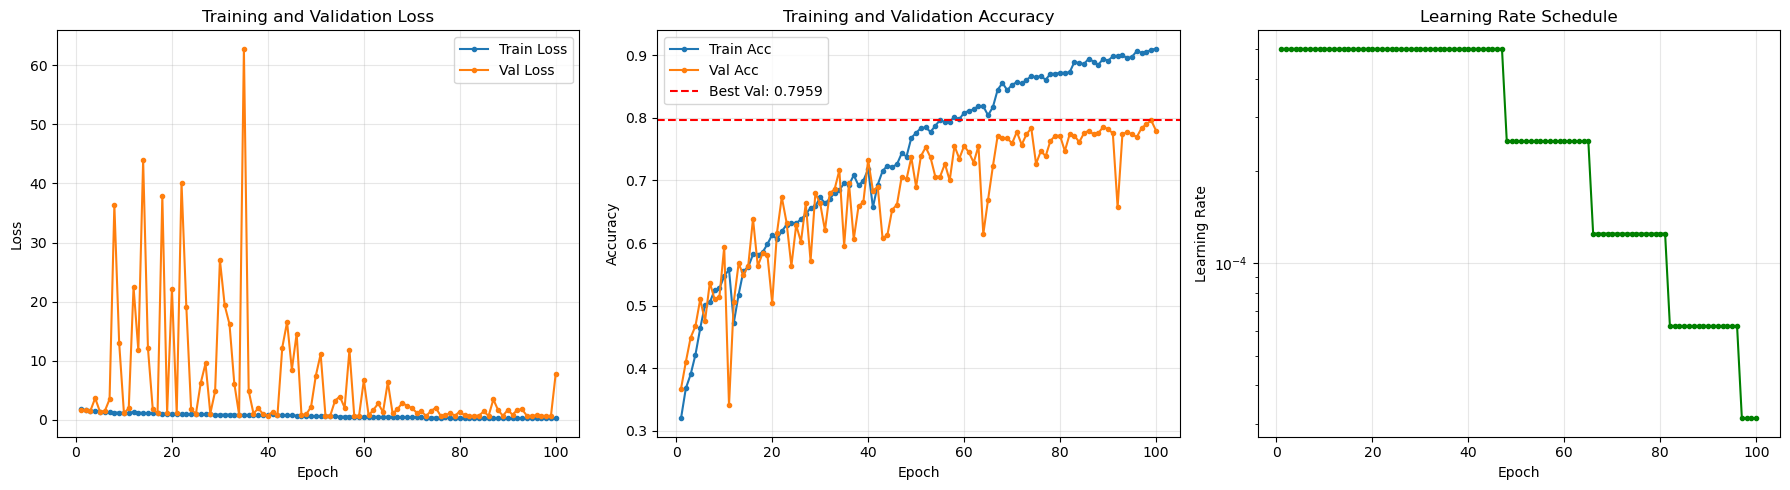


📊 Training Summary:
   Final train accuracy: 0.9102
   Final val accuracy: 0.7796
   Best val accuracy: 0.7959 (epoch 99)
   Improvement: 0.6531 over random baseline


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

epochs_range = range(1, len(history_enhanced['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history_enhanced['train_loss'], label='Train Loss', marker='o', markersize=3)
axes[0].plot(epochs_range, history_enhanced['val_loss'], label='Val Loss', marker='o', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history_enhanced['train_acc'], label='Train Acc', marker='o', markersize=3)
axes[1].plot(epochs_range, history_enhanced['val_acc'], label='Val Acc', marker='o', markersize=3)
axes[1].axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best Val: {best_val_acc:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(epochs_range, history_enhanced['learning_rate'], marker='o', markersize=3, color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n📊 Training Summary:")
print(f"   Final train accuracy: {history_enhanced['train_acc'][-1]:.4f}")
print(f"   Final val accuracy: {history_enhanced['val_acc'][-1]:.4f}")
print(f"   Best val accuracy: {best_val_acc:.4f} (epoch {best_epoch})")
print(f"   Improvement: {(best_val_acc - 1/num_classes):.4f} over random baseline")

In [ ]:
print("Loading best model...")
checkpoint = torch.load('best_gnn_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded model from epoch {checkpoint['epoch']} with val_acc={checkpoint['val_acc']:.4f}")

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

print("\n" + "=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")
print("=" * 60)

Loading best model...
✓ Loaded model from epoch 99 with val_acc=0.7959

TEST SET EVALUATION
   Test Loss: 0.5910
   Test Accuracy: 0.7878


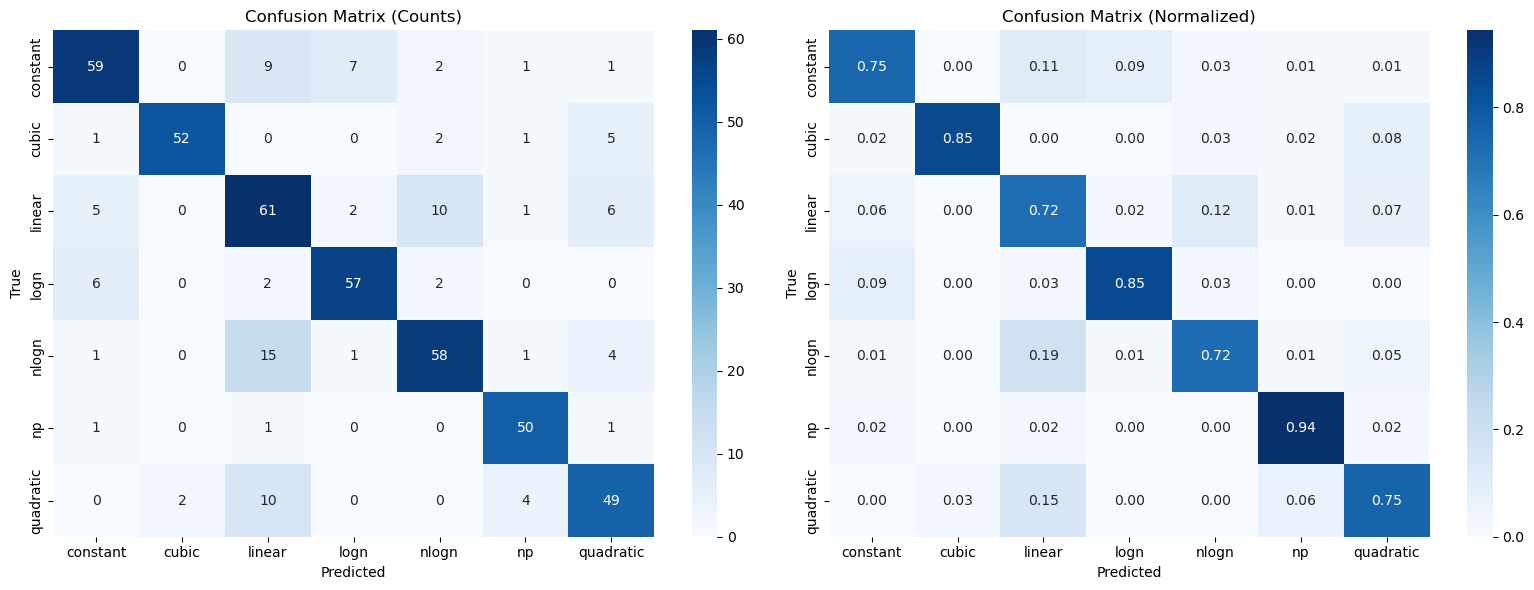


📊 Classification Report:
              precision    recall  f1-score   support

    constant     0.8082    0.7468    0.7763        79
       cubic     0.9630    0.8525    0.9043        61
      linear     0.6224    0.7176    0.6667        85
        logn     0.8507    0.8507    0.8507        67
       nlogn     0.7838    0.7250    0.7532        80
          np     0.8621    0.9434    0.9009        53
   quadratic     0.7424    0.7538    0.7481        65

    accuracy                         0.7878       490
   macro avg     0.8047    0.7986    0.8000       490
weighted avg     0.7942    0.7878    0.7894       490



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[label_to_complexity[i] for i in range(num_classes)],
            yticklabels=[label_to_complexity[i] for i in range(num_classes)])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=axes[1],
            xticklabels=[label_to_complexity[i] for i in range(num_classes)],
            yticklabels=[label_to_complexity[i] for i in range(num_classes)])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix (Normalized)')

plt.tight_layout()
plt.show()

# Classification report
print("\n📊 Classification Report:")
print("=" * 60)
target_names = [label_to_complexity[i] for i in range(num_classes)]
print(classification_report(test_labels, test_preds, target_names=target_names, digits=4))


📊 Per-Class Test Accuracy:
Complexity  Accuracy  Correct  Total
  constant  0.746835       59     79
     cubic  0.852459       52     61
    linear  0.717647       61     85
      logn  0.850746       57     67
     nlogn  0.725000       58     80
        np  0.943396       50     53
 quadratic  0.753846       49     65


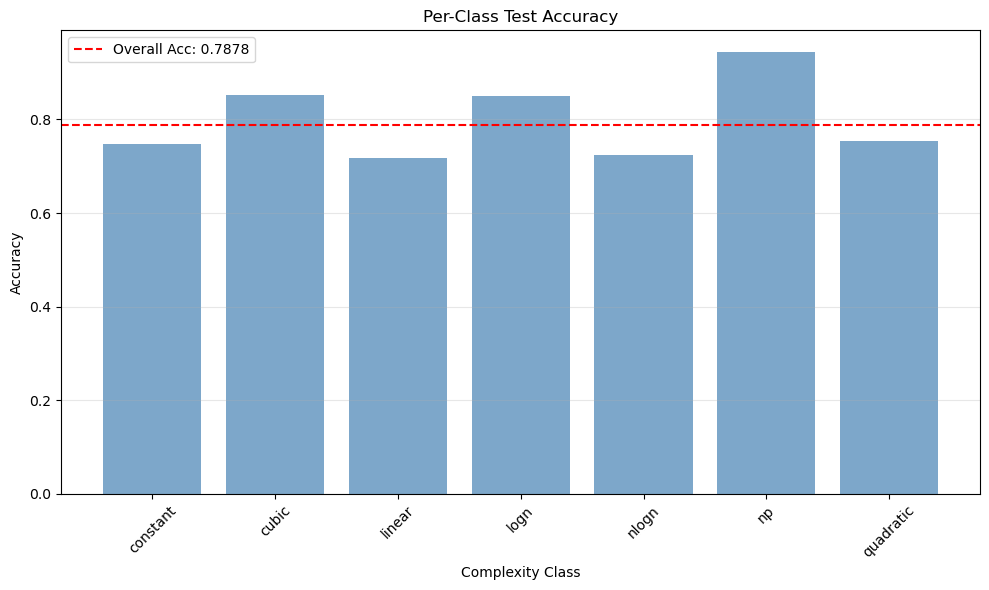

In [ ]:
from collections import defaultdict

# Group by true label
class_correct = defaultdict(int)
class_total = defaultdict(int)

for true_label, pred_label in zip(test_labels, test_preds):
    class_total[true_label] += 1
    if true_label == pred_label:
        class_correct[true_label] += 1

# Calculate per-class accuracy
class_accuracies = []
for i in range(num_classes):
    acc = class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    class_accuracies.append({
        'Complexity': label_to_complexity[i],
        'Accuracy': acc,
        'Correct': class_correct[i],
        'Total': class_total[i]
    })

# Create DataFrame
class_acc_df = pd.DataFrame(class_accuracies)
print("\n📊 Per-Class Test Accuracy:")
print(class_acc_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(range(num_classes), class_acc_df['Accuracy'], color='steelblue', alpha=0.7)
plt.xticks(range(num_classes), class_acc_df['Complexity'], rotation=45)
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Overall Acc: {test_acc:.4f}')
plt.ylabel('Accuracy')
plt.xlabel('Complexity Class')
plt.title('Per-Class Test Accuracy')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
def predict_code_complexity(code: str, model, ast_converter, complexity_to_label, label_to_complexity, device):
    """
    Predict the complexity class of a single code snippet.
    
    Args:
        code: Python source code string
        model: Trained GNN model
        ast_converter: ASTGraphConverter instance with built vocabulary
        complexity_to_label: Dict mapping complexity string to label index
        label_to_complexity: Dict mapping label index to complexity string
        device: torch device
    
    Returns:
        Dict with:
            - 'predicted_class': Predicted complexity class (string)
            - 'confidence': Confidence score (float)
            - 'probabilities': All class probabilities (dict)
    """
    model.eval()
    
    try:
        # Convert code to graph
        graph = ast_converter.code_to_graph(code)
        
        # Create node features tensor
        node_ids = torch.tensor(graph['node_ids'], dtype=torch.long)
        x = node_ids.unsqueeze(1)  # Shape: [num_nodes, 1]
        
        # Create edge index tensor
        if len(graph['edges']) > 0:
            edge_index = torch.tensor(graph['edges'], dtype=torch.long).t().contiguous()
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
        
        # Create PyG Data object
        data = Data(x=x, edge_index=edge_index)
        
        # Create a batch with single graph
        batch = torch.zeros(x.shape[0], dtype=torch.long)
        data.batch = batch
        
        # Move to device
        data = data.to(device)
        
        # Forward pass
        with torch.no_grad():
            logits = model(data)
            probabilities = F.softmax(logits, dim=1)
            predicted_label = torch.argmax(logits, dim=1).item()
        
        # Get results
        probs_np = probabilities.cpu().numpy().squeeze()
        predicted_class = label_to_complexity[predicted_label]
        confidence = probs_np[predicted_label]
        
        # Create probability dict for all classes
        prob_dict = {label_to_complexity[i]: float(probs_np[i]) for i in range(len(probs_np))}
        
        return {
            'predicted_class': predicted_class,
            'predicted_label': predicted_label,
            'confidence': float(confidence),
            'probabilities': prob_dict
        }
    
    except Exception as e:
        return {
            'predicted_class': 'error',
            'error': str(e)
        }


# Test the function
i = 40

test_code_sample = test_samples[i]['code']
test_code_sample_complexity = test_samples[i]['complexity']
result = predict_code_complexity(
    test_code_sample, model, ast_converter, 
    complexity_to_label, label_to_complexity, device
)

print("=" * 60)
print("PREDICTION RESULT")
print("=" * 60)
print(f"Predicted Class: {result['predicted_class']}")
print(f"Actual Class:    {test_code_sample_complexity}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Match: {'✓' if result['predicted_class'] == test_code_sample_complexity else '✗'}")
print(f"\nAll Class Probabilities:")
sorted_probs = sorted(result['probabilities'].items(), key=lambda x: x[1], reverse=True)
for complexity, prob in sorted_probs:
    bar = '█' * int(prob * 50)
    marker = '← PREDICTED' if complexity == result['predicted_class'] else ''
    marker += ' (ACTUAL)' if complexity == test_code_sample_complexity else ''
    print(f"   {complexity:12s}: {prob:.4f} {bar} {marker}")
print("=" * 60)